# AiHeart : Heart Disease Classification - Cleveland

**Table of Content**

1. [Project goal](#chapter1)
2. [Dataset](#chapter2)
3. [Data preprocessing](#chapter3)
4. [Baseline modelling](#chapter4)
    * [4.1 Baseline modelling results](#chapter41)
5. [Optimizing the Hyperparameters](#chapter5)
    * [5.1 Linear regression](#chapter51)
        * [5.1.1 Result Linear regression](#chapter511)
        * [5.1.2 Feature selection for Linear regression](#chapter512)
    * [5.2 DT](#chapter52)
        * [5.2.1 Result DT](#chapter521)
        * [5.2.2 Feature selection for DT](#chapter522)
    * [5.3 RF](#chapter53)
        * [5.3.1 Result RF](#chapter531)
        * [5.3.2 Feature selction for RF](#chapter532)
    * [5.4 KNN](#chapter54)
        * [5.4.1 Result KNN](#chapter541)
    * [5.5 SVM](#chapter55)
        * [5.5.1 Result SVM](#chapter551)
        * [5.5.2 Feature selection for SVM](#chapter552)
    * [5.6 Gradient Boosted Tree](#chapter56)
        * [5.6.1 Result Gradient Boosted Tree](#chapter561)
        * [5.6.2 Feature selection for Boosted Tree](#chapter562)
    * [5.7 XGBoost](#chapter57)
        * [5.7.1 Result XGBoost](#chapter571)
    * [5.8 Perceptron](#chapter58)
        * [5.8.1 Result Perceptron](#chapter581)
6. [Result optimization](#chapter6)
    * [6.1 Choice of best optimizer](#chapter61)


---

# 1. Project goal <a class="anchor" id="chapter1"></a>

- Given clinical parameters about a patient in a primary care setting in the north of Sweden, predict if a patient has Heart Disease or not

---

# 2. Dataset <a class="anchor" id="chapter2"></a>

Dataset: UCI Heart Disease dataset available at the UCI Machine Learning data repository - http://archive.ics.uci.edu/ml/datasets/Heart+Disease

We decided to use only the Cleveland dataset (explanation in the report).


### Features in Dataset
- There are 14 features in the original Cleveland dataset
1. `age`: Age of the patient in years
2. `sex`: 1 = Male, 0 = Female
3. `cp`: chest pain type, 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic
4. `trestbps`: resting blood pressure in mmHg on admission to the hospital
5. `chol`: serum cholesterol in mg/dl
6. `fbs`: if fasting blood sugar > 120 mg/dl, 1 = true, 0 = false
7. `restecg`: resting electrocardiographic results, 0 = normal, 1 = having ST-T wave abnormality, 2 = probable or definite left ventricular hypertrophy by Estes' criteria
8. `thalach`: maximum heart rate achieved
9. `exang`: exercise-induced angina, 1 = yes, 0 = no
10. `oldpeak`: ST depression induced by exercise relative to rest
11. `slope`: the slope of the peak exercise ST segment, 1 = upsloping, 2 = flat, 3 = downsloping
12. `ca`: number of major vessels (0-3) colored by fluoroscopy
13. `thal`: defect type, 3 = normal, 6 = fixed defect, 7 = reversible defect
14. `num`: diagnosis of heart disease (angiographic disease status)

### Data type
These are the features according to data type:

- Categorical features: `sex`, `cp`, `restecg`, `slope`, `ca`, `thal`
- Binary features: `exang`, `fbs`, `num`
- Numerical features: `age`, `trestbps`, `chol`, `thalach`, `oldpeak`

### Class Label
- The predicted class label is `num` that we will replace it with the name `target` 
- The "goal" of the application refers to the presence of Heart Disease in the patient. As the physicians are only interested in knowing if the patient is sick or not, we decided to create a **binary classification model** only predicting the presence of Heart Disease, e.i. 0 = no presence of Heart Disease, and 1 (including 1,2,3,4 values) = presence of Heart Disease.

---

# 3. Data preprocessing <a class="anchor" id="chapter3"></a>

- There are 303 records in this dataset
- We decided to exclude the variables `ca` and `thal` from our application (due to medical procedures reasons, see report).
- Visual inspection of the dataframe shows there are 6 missing values. These are in `ca`,`thal` columns, but as we will drop these columns, it does not impact the final dataset.
- That's why we do not need to handle any missing values

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import loguniform
from sklearn.neural_network import MLPClassifier

In [2]:
df = pd.read_table("processed.cleveland.csv")
df.drop(["ca", "thal"], axis=1, inplace=True)
df.rename(columns={"num": "target"}, inplace=True)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1


In [3]:
# Checking that there are no null values that our visual inpsection missed
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
target      0
dtype: int64

In [4]:
# Change target labels to 1 and 0 to create a binary classification problem.
df["target"] = df["target"].replace([2, 3, 4], 1)

In [5]:
# Variable types
df.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
target        int64
dtype: object

#### The variables types are

1. Binary: `fbs`, `exang` , `target`
2. Categorical: `cp`, `restecg`, `slope`, `sex`
3. Continuous: `age`, `trestbps`, `chol` , `thalac`, `oldpeak`

In [6]:
# Change to appropriate datatype. 
df.cp = df.cp.astype("category")
df.restecg = df.restecg.astype("category")
df.slope = df.slope.astype("category")
df.sex = df.sex.astype("category")
df.fbs = df.fbs.astype("bool")
df.exang = df.exang.astype("bool")
df.target = df.target.astype("bool")
df.dtypes

age          float64
sex         category
cp          category
trestbps     float64
chol         float64
fbs             bool
restecg     category
thalach      float64
exang           bool
oldpeak      float64
slope       category
target          bool
dtype: object

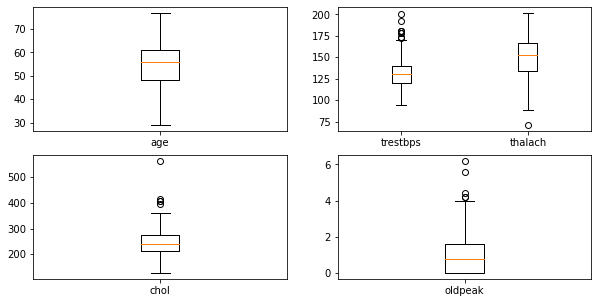

In [7]:
# Check numeric variables for outliers
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,
                                             ncols=2,
                                             figsize=(10, 5))
ax1.boxplot(df['age'], labels=['age']);
ax2.boxplot([df['trestbps'], df['thalach']], labels=['trestbps', 'thalach']);
ax3.boxplot(df['chol'], labels=['chol']);
ax4.boxplot(df['oldpeak'], labels=['oldpeak']);

- There are some outliers for `trestbps`, `thalach`, `chol` and `oldpeak`
- Verified with medical doctor - values are plausible hence these values are kept in the dataset

In [8]:
# Check class balance - 164 patients have label False ( 0, no heart disease), 139 patients have label True ( 1, heart disease)
df["target"].value_counts()

False    164
True     139
Name: target, dtype: int64

<AxesSubplot:>

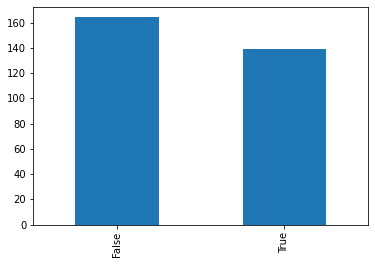

In [9]:
# Plot class balance
df["target"].value_counts().plot.bar()

### Preparing dataframes for Classification Tasks

This step is to **transform the pandas DataFrame into numerical Numpy arrays**, so that they can be processed by the packages in `sklearn`. At this stage, we need to **encode the categorical features** .

### One-hot encoding

In [10]:
# Perform one-hot encoding for categorical variables
df_processed = pd.get_dummies(df, columns=["sex","cp","restecg","slope"])

In [11]:
df_processed 

,age,trestbps,chol,fbs,thalach,exang,oldpeak,target,sex_0.0,sex_1.0,cp_1.0,cp_2.0,cp_3.0,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0
0,63.0,145.0,233.0,True,150.0,False,2.3,False,0,1,1,0,0,0,0,0,1,0,0,1
1,67.0,160.0,286.0,False,108.0,True,1.5,True,0,1,0,0,0,1,0,0,1,0,1,0
2,67.0,120.0,229.0,False,129.0,True,2.6,True,0,1,0,0,0,1,0,0,1,0,1,0
3,37.0,130.0,250.0,False,187.0,False,3.5,False,0,1,0,0,1,0,1,0,0,0,0,1
4,41.0,130.0,204.0,False,172.0,False,1.4,False,1,0,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,110.0,264.0,False,132.0,False,1.2,True,0,1,1,0,0,0,1,0,0,0,1,0
299,68.0,144.0,193.0,True,141.0,False,3.4,True,0,1,0,0,0,1,1,0,0,0,1,0
300,57.0,130.0,131.0,False,115.0,True,1.2,True,0,1,0,0,0,1,1,0,0,0,1,0
301,57.0,130.0,236.0,False,174.0,False,0.0,True,1,0,0,1,0,0,0,0,1,0,1,0


In [12]:
# Convert to numeric the columns that are binary
df_processed["fbs"] = df_processed["fbs"].astype(int)
df_processed["exang"] = df_processed["exang"].astype(int)
df_processed["target"] = df_processed["target"].astype(int)


### Choose features 

**Correlation Matrix with Heatmap**

Correlation indicates how the features are related to each other or to the target variable. The correlation may be positive (increase in one value of the feature increases the value of the target variable) or negative (increase in one value of the feature decreases the value of the target variable). Heatmap makes it easy to classify the features that are most relevant to the target variable, and we will plot the associated features of the heatmap using the seaborn library.

<AxesSubplot:>

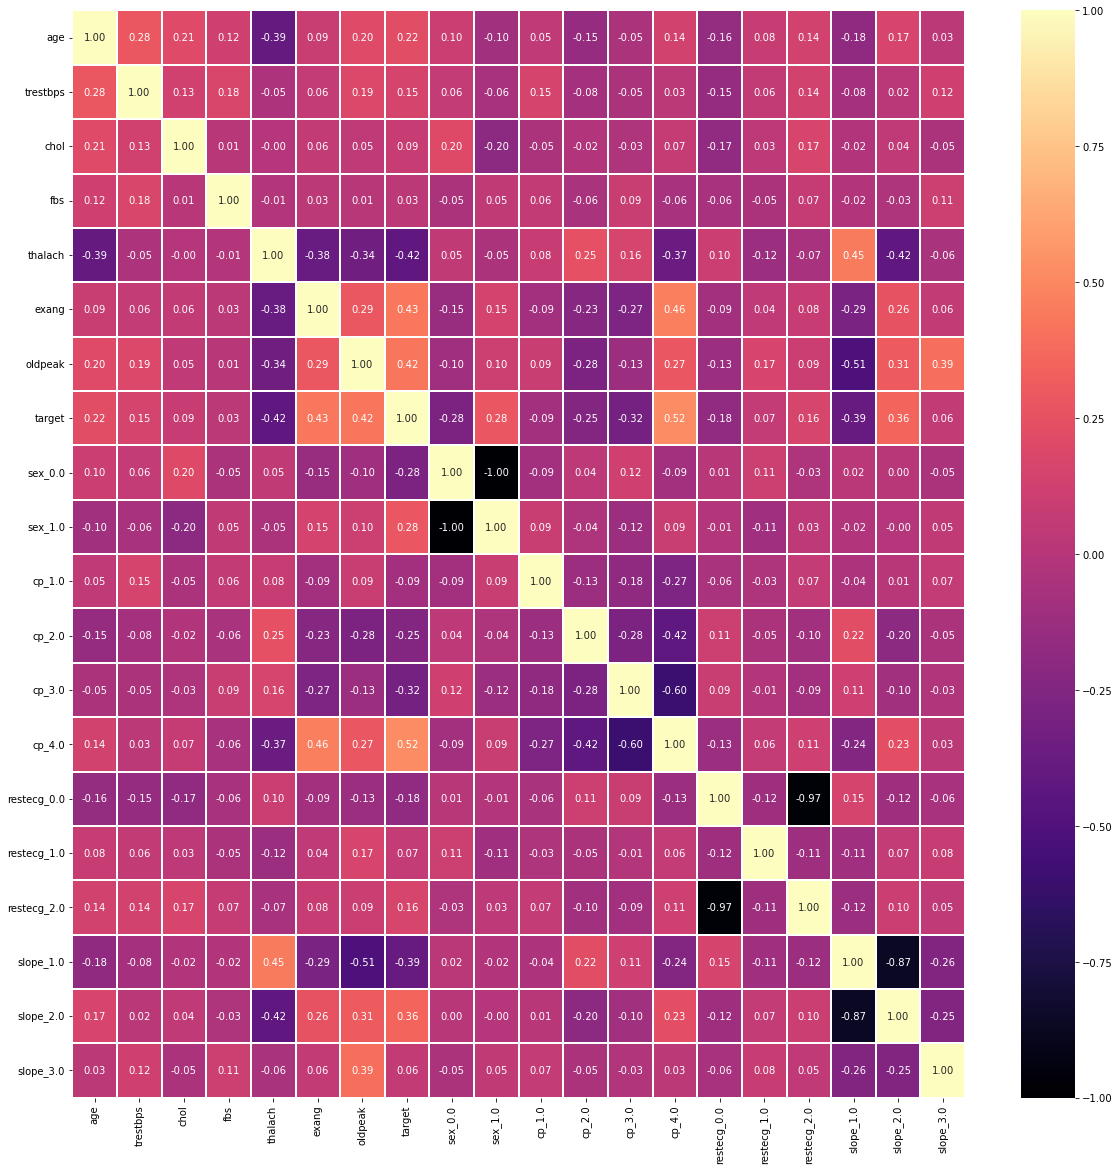

In [13]:
plt.figure(figsize=(20,20))
sns.heatmap(df_processed.corr(),annot=True,cmap="magma",fmt=".2f", linewidths=.10)

- From the correlation matrix it seems that the `exang`, `oldpeak`, `sex`, `age`, `slope_2`and `cp_4` are more correlated with the `target `(the presense of heart disease or not) 
- `exang`: Exercise induced angina (1 = yes; 0 = no)
- `oldpeak`: ST depression induced by exercise relative to rest 
- `slope_2`:the slope of the peak exercise ST segment — 2: upsloping
- `cp_4`:chest pain type - 4: typical angina
- `sex`, 
- `age`

---

# 4. Baseline modelling <a class="anchor" id="chapter4"></a>

- We have referred to the flowchart provided in the following site that gave us a rough guide on how to approach problems concerning which estimators to try on our data. https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
- Models we have used initially are the following: Logistic Regression, DT, RF,KNN,SVC, Gradient Boosted Tree (GBDT), Extreme Gradient Boosting (XGBoost), and AdaBoost.

In [14]:
np.random.seed(42)

In [15]:
# Defining feature vector and class labels
X = df_processed.drop("target", axis=1)
y = df_processed["target"]

In [16]:
# Finally, we need transform from Pandas DataFrame to numerical Arrays, and store the column names
data_X = X.values
data_y = y.values

data_colnames = X.columns.values
print(data_colnames)

['age' 'trestbps' 'chol' 'fbs' 'thalach' 'exang' 'oldpeak' 'sex_0.0'
 'sex_1.0' 'cp_1.0' 'cp_2.0' 'cp_3.0' 'cp_4.0' 'restecg_0.0' 'restecg_1.0'
 'restecg_2.0' 'slope_1.0' 'slope_2.0' 'slope_3.0']


In [17]:
# Normalisation of feature vector since SVC and KNN require normalisation
scaler = MinMaxScaler()
data_X = scaler.fit_transform(data_X)

### Final feature matrix $\mathbf{X}$

In [18]:
data_X

array([[0.70833333, 0.48113208, 0.24429224, ..., 0.        , 0.        ,
        1.        ],
       [0.79166667, 0.62264151, 0.3652968 , ..., 0.        , 1.        ,
        0.        ],
       [0.79166667, 0.24528302, 0.23515982, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.58333333, 0.33962264, 0.01141553, ..., 0.        , 1.        ,
        0.        ],
       [0.58333333, 0.33962264, 0.25114155, ..., 0.        , 1.        ,
        0.        ],
       [0.1875    , 0.41509434, 0.11187215, ..., 1.        , 0.        ,
        0.        ]])

### Final target array $\mathbf{y}$

In [19]:
data_y

array([0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,

### Cross Validation
As the dataset is pretty small (normally < 300), a single train-test split has a significant problem. Normally there is a fraction of the dataset that is a holdout for testing and never goes in the training process, but with a small dataset, we want to use as much data as possible to train our model.

Cross-validation (CV) is a strategy to solve the problem of single train-test split and **the correct approach** to evaluate model performance for small datasets. The CV partitions a dataset into `k` folds or groups. It then uses all but one of the folds as training data and the final fold as test data. In subsequent loops, CV uses the other folds, one at a time, as test set, while the remaining folds form the training set. Statistics are measured for each loop, and the average accuracy etc, is finally calculated over all loops.

This also means that a CV creates `k` different classification models instead of only one. It might be time-consuming for classifiers that take a lot of time to train or large datasets.

Yet another consideration when using CV is when the target classes are very imbalanced, then **stratified k-fold cross validation** is a better option. In our dataset, however, the sick/non-sick people are roughly the same.

### Baseline model evaluation with CV

In [20]:
# Collate models, metrics and evaluation statistics
models = {
    "Logistic Regression": LogisticRegression(),
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "GBDT": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC()}


metrics = ["accuracy", "precision_macro", "recall_macro", "f1_macro", "roc_auc"]

result_eval = pd.DataFrame({ "classifier_name":[],
                                    "fit_time": [],
                                    "score_time": [],
                                    "test_accuracy": [],
                                    "test_precision_macro": [],
                                    "test_recall_macro": [],
                                    "test_f1_macro": []
                                    })

In [21]:
# Testing and evaluating models 
for name, classifier in models.items():
    
    np.random.seed(42)
        
    scores_cv = cross_validate(classifier, data_X, data_y, cv=5, scoring=metrics)

    dict_this_result = {"classifier_name":[name],}
    
    for metric_name, score_per_fold in scores_cv.items():
        dict_this_result[metric_name] = [scores_cv[metric_name].mean()]

    this_result = pd.DataFrame(dict_this_result)
    result_eval = pd.concat([result_eval, this_result], ignore_index=True)

## 4.1. Baseline model result <a class="anchor" id="chapter41"></a>

In [22]:
result_eval

,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc
0,Logistic Regression,0.003354,0.002045,0.778852,0.779359,0.776631,0.776390,0.882522
1,DT,0.000802,0.001647,0.683224,0.682273,0.679004,0.678981,0.679004
2,RF,0.071501,0.010982,0.769071,0.770251,0.767226,0.766973,0.852734
3,KNN,0.000168,0.009762,0.762568,0.763770,0.763814,0.761660,0.807423
4,SVM,0.002743,0.003600,0.775683,0.777530,0.777691,0.774883,0.852366
5,GBDT,0.047196,0.002179,0.765519,0.767636,0.760961,0.761306,0.840292
6,XGBoost,0.030101,0.003371,0.772186,0.776667,0.769545,0.768755,0.822226
7,AdaBoost,0.035655,0.008534,0.742459,0.744710,0.738692,0.736954,0.796248


From the baseline testing and the evaluation regarding recall and F1 (se explanation in report) of the different classifier  that we chose, one can see that som classifiers performs better such as `Logistic Regression`, `XGBoost`, `SVM`, `Random Forest` in comparison to the others `GBDT`, `AdaBoost`, then `KNN` and finally `Decision Tree`.

So let's start optimizing the hyperparameters in the algorithms!

---

# 5. Optimizing the Hyperparameters <a class="anchor" id="chapter5"></a>

We chose to optimize `Logistic Regression`, `Decision Tree`, `Random Forest`, `KNN` and `SVC` as the most traditional classifiers we learned about in our courses. We also thought to use the `Graded Boosted Tree` and `XGBoost`as we have found after research that they can provide good results. However, we skipped `AdaBoost` as it has not shown some outstanding results in the baseline modeling. Finally, we decided to use also a simple Deep Learning model, `Perceptron`.

Setting up for optimizing:

## 5.1 Logistic Regression <a class="anchor" id="chapter51"></a>

In [23]:
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

rs_log_reg = RandomizedSearchCV(LogisticRegression(), 
                                param_distributions=log_reg_grid,
                               cv=5,
                               n_iter=20,
                               verbose=True, 
                               random_state=42)

rs_log_reg.fit(data_X, data_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   random_state=42, verbose=True)

In [24]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 11.288378916846883}

In [25]:
rs_log_reg.best_estimator_

LogisticRegression(C=11.288378916846883, solver='liblinear')

In [26]:
#Print out the result
dt_model={"Logistic Regression": LogisticRegression(C=11.288378916846883, solver='liblinear')}

for name, classifier in dt_model.items():
    
    np.random.seed(42)
    
    scores_cv = cross_validate(classifier, data_X, data_y, cv=5, scoring=metrics)

    dict_lr_result = {"classifier_name":[name],}
    
    for metric_name, score_per_fold in scores_cv.items():
        dict_lr_result[metric_name] = [scores_cv[metric_name].mean()]

    dt_result = pd.DataFrame(dict_lr_result)
    df_finalresult = pd.DataFrame(dict_lr_result)

dt_result

,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc
0,Logistic Regression,0.000593,0.001814,0.791967,0.794689,0.789388,0.78926,0.881489


### 5.1.1 Result for optimized Logistic regression <a class="anchor" id="chapter511"></a>

* Accuracy = 0.791
* Precision = 0.795
* Recall = 0.789
* F1 = 0.789
* AUC = 0.881

With hyperparameters setting: 
- C = 11.288
- solver = 'liblinear'


### 5.1.2 Feature selection for Logistic regression <a class="anchor" id="chapter512"></a>

We decided to try a feature selection algorithm (RFE) to see if by excluding some of the features the performance parameters could improve. We tried different numbers of features and the best was chosen.


In [27]:
#Feature selecting and visualizing the new dataset with only selected features, for Logistic Regression
from sklearn.feature_selection import RFE
select_lr = RFE(LogisticRegression(), n_features_to_select= 10)
X_newlr = select_lr.fit_transform(data_X, data_y)

pd.DataFrame(X_newlr).head()

,0,1,2,3,4,5,6,7,8,9
0,0.708333,0.481132,0.244292,0.603053,0.0,0.370968,0.0,1.0,0.0,0.0
1,0.791667,0.622642,0.365297,0.282443,1.0,0.241935,0.0,1.0,1.0,1.0
2,0.791667,0.245283,0.235160,0.442748,1.0,0.419355,0.0,1.0,1.0,1.0
3,0.166667,0.339623,0.283105,0.885496,0.0,0.564516,0.0,1.0,0.0,0.0
4,0.250000,0.339623,0.178082,0.770992,0.0,0.225806,1.0,0.0,0.0,0.0


In [28]:
#Listing the columns that represent the selected features
list(np.take(X.columns, np.where(select_lr.support_ == True)))

['age',
 'trestbps',
 'chol',
 'thalach',
 'exang',
 'oldpeak',
 'sex_0.0',
 'sex_1.0',
 'cp_4.0',
 'slope_2.0']

In [29]:
#See how each of the columns were ranked by RFE
select_lr.ranking_

array([ 1,  1,  1, 10,  1,  1,  1,  1,  1,  4,  6,  5,  1,  3,  7,  8,  2,
        1,  9])

In [30]:
# Presenting in a dataframe the ranking of each feature. Features ranked in the 1st place were selected by RFE.
#The lower the rank (e.g 11th), the sooner RFE excluded it.
selectedfeature_lr = pd.DataFrame({'Feature': list(X.columns),
                                 'Rank': select_lr.ranking_})
selectedfeature_lr.sort_values(by = 'Rank')

,Feature,Rank
0,age,1
1,trestbps,1
2,chol,1
4,thalach,1
5,exang,1
6,oldpeak,1
7,sex_0.0,1
8,sex_1.0,1
17,slope_2.0,1
12,cp_4.0,1


In [31]:
#Print out the result for RFE selected features of LR
dt_model={"LR with RFE": LogisticRegression(C=11.288378916846883, solver='liblinear')}

for name, classifier in dt_model.items():
    
    np.random.seed(42)
    
    scores_cv = cross_validate(classifier, X_newlr, data_y, cv=5, scoring=metrics)

    dict_lr_result = {"classifier_name":[name],}
    
    for metric_name, score_per_fold in scores_cv.items():
        dict_lr_result[metric_name] = [scores_cv[metric_name].mean()]

    dt_result = pd.DataFrame(dict_lr_result)
    df_finalresult = df_finalresult.append(pd.DataFrame(dict_lr_result))

dt_result

/var/folders/5k/4cpsyd4915ld3szp5dw41nq40000gn/T/ipykernel_18189/304609535.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_finalresult = df_finalresult.append(pd.DataFrame(dict_lr_result))


,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc
0,LR with RFE,0.000547,0.001841,0.805301,0.806232,0.803749,0.803491,0.894094


### 5.1.2 Result for optimized Linear regression with feature selection <a class="anchor" id="chapter512"></a>

* Accuracy = 0.805
* Precision = 0.806
* Recall = 0.804
* F1 = 0.803
* AUC = 0.894

---

## 5.2 Decision Tree <a class="anchor" id="chapter52"></a>

Decision Tree(DT) classifier is a kind of classification model and has a flow-chart like tree structure based on if-then statement. In terms of generating the classifier, at first, all training samples are at a root, and then partitioned based on selected attributes (Tree construction). Afterwards, unneccessary branches are identified and removed to decrease outliers (Tree pruning). Finally, by using a test set, the model classifies unknown(test) samples.
Advantages of DT would be easy application and implementation, reasonable training time, and the possibility of handling large number of features. However, due to simple decision boundaries, DT has risks of missing data and difficulties on handling complicated relationships between features.

In [32]:
#Apply grid search to find the best parameters in Decision Tree classifier

np.random.seed(42)

dt_params = {"criterion":['gini','entropy','log_loss'],
             "splitter":['best','random'],
             "max_depth":[2,5,10],
             "min_weight_fraction_leaf":[0,0.25,0.5],
             "max_features":['auto','sqrt','log2']          
             }
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, verbose=5, n_jobs=-1)
dt_grid.fit(data_X, data_y)
dt_grid.best_score_

Fitting 5 folds for each of 162 candidates, totalling 810 fits


/Users/orka/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/orka/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/orka/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/orka/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max

/Users/orka/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/orka/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/orka/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/orka/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max

0.7655737704918033

In [33]:
dt_grid.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_weight_fraction_leaf': 0,
 'splitter': 'random'}

In [34]:
dt_grid.best_estimator_

DecisionTreeClassifier(max_depth=5, max_features='auto',
                       min_weight_fraction_leaf=0, random_state=42,
                       splitter='random')

In [35]:
#Print out the result
dt_model={"Decision Tree":DecisionTreeClassifier(max_depth=dt_grid.best_params_['max_depth'], max_features=dt_grid.best_params_['max_features'],
                                                 min_weight_fraction_leaf=dt_grid.best_params_['min_weight_fraction_leaf'], splitter=dt_grid.best_params_['splitter'],random_state=42)}

for name, classifier in dt_model.items():
    
    np.random.seed(42)
    
    scores_cv = cross_validate(classifier, data_X, data_y, cv=5, scoring=metrics)

    dict_dt_result = {"classifier_name":[name],}
    
    for metric_name, score_per_fold in scores_cv.items():
        dict_dt_result[metric_name] = [scores_cv[metric_name].mean()]

    dt_result = pd.DataFrame(dict_dt_result)
    df_finalresult = df_finalresult.append(pd.DataFrame(dict_dt_result))

dt_result

/Users/orka/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/orka/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/orka/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/orka/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max

,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc
0,Decision Tree,0.000714,0.002301,0.765574,0.778168,0.757116,0.757072,0.809711


### 5.2.1 Result for optimized DT <a class="anchor" id="chapter521"></a>

* Accuracy = 0.766
* Precision = 0.778
* Recall = 0.757
* F1 = 0.757
* AUC = 0.809


### 5.2.2 Feature selection for DT <a class="anchor" id="chapter522"></a>

In [36]:
#The logic is described above. Showing only the final dataframe with the rankings for each feature
select_dt = RFE(DecisionTreeClassifier(random_state=42), n_features_to_select= 13)
X_newdt = select_dt.fit_transform(data_X, data_y)

selectedfeature_dt = pd.DataFrame({'Feature': list(X.columns),
'Rank': select_dt.ranking_})
selectedfeature_dt.sort_values(by = 'Rank')

,Feature,Rank
0,age,1
13,restecg_0.0,1
12,cp_4.0,1
11,cp_3.0,1
17,slope_2.0,1
15,restecg_2.0,1
8,sex_1.0,1
5,exang,1
4,thalach,1
2,chol,1


In [37]:
#Print out the results for DT with feature selection
dt_model={"DT with RFE":DecisionTreeClassifier(max_depth=dt_grid.best_params_['max_depth'], max_features=dt_grid.best_params_['max_features'],
                                                 min_weight_fraction_leaf=dt_grid.best_params_['min_weight_fraction_leaf'], splitter=dt_grid.best_params_['splitter'], random_state=42)}

for name, classifier in dt_model.items():
    
    np.random.seed(42)
    
    scores_cv = cross_validate(classifier, X_newdt, data_y, cv=5, scoring=metrics)

    dict_dt_result = {"classifier_name":[name],}
    
    for metric_name, score_per_fold in scores_cv.items():
        dict_dt_result[metric_name] = [scores_cv[metric_name].mean()]

    dt_result = pd.DataFrame(dict_dt_result)
    df_finalresult = df_finalresult.append(pd.DataFrame(dict_dt_result))

dt_result

/Users/orka/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/orka/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/orka/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/orka/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max

,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc
0,DT with RFE,0.000975,0.002407,0.752514,0.752632,0.753489,0.751558,0.818561


### 5.2.2 Result for optimized Decision Tree with feature selection <a class="anchor" id="chapter522"></a>

* Accuracy = 0.753
* Precision = 0.753
* Recall = 0.753
* F1 = 0.752
* AUC = 0.819

---

## 5.3 Random Forest <a class="anchor" id="chapter53"></a>

In [38]:
# Check range of best parameters with randomized search CV
# This code takes a while to run so I've commented it out


np.random.seed(42)

# Randomized parameters grid 
rf_rs_params = {"n_estimators" : np.arange(100, 1000, 50),
                "max_depth": [None, 10, 20, 30],
                "min_samples_split": np.arange(2, 20, 2),
                "min_samples_leaf": np.arange(1, 20, 2)}

# Instantiate RandomizedSearchCV
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                    param_distributions=rf_rs_params,
                    cv=5,
                    n_iter=20,
                    verbose=1)

# Fit to data
rs_rf.fit(data_X, data_y)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700,
       750, 800, 850, 900, 950])},
                   verbose=1)

In [39]:
# Check best hyperparameters
rs_rf.best_params_

{'n_estimators': 250,
 'min_samples_split': 10,
 'min_samples_leaf': 17,
 'max_depth': 30}

In [40]:
rs_rf.best_score_

0.7820765027322404

In [41]:
# Use grid search to find best parameters within smaller range of hyperparameters 
# This code takes a while to run so I've commented it out

np.random.seed(42)

rf_gs_params = {"n_estimators" : np.arange(800, 1000, 50),
                "max_depth": [20, 30, 40],
                "min_samples_split": np.arange(14, 18, 2),
                "min_samples_leaf": np.arange(8, 10, 1)}

gs_rf = GridSearchCV(RandomForestClassifier(),
                    param_grid=rf_gs_params,
                    cv=5, 
                    verbose=1)

gs_rf.fit(data_X, data_y)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [20, 30, 40],
                         'min_samples_leaf': array([8, 9]),
                         'min_samples_split': array([14, 16]),
                         'n_estimators': array([800, 850, 900, 950])},
             verbose=1)

In [42]:
gs_rf.best_params_

{'max_depth': 30,
 'min_samples_leaf': 9,
 'min_samples_split': 16,
 'n_estimators': 850}

In [43]:
gs_rf.best_estimator_

RandomForestClassifier(max_depth=30, min_samples_leaf=9, min_samples_split=16,
                       n_estimators=850)

In [44]:
#Print out the result
dt_model={"Random Forest":RandomForestClassifier(max_depth=30, min_samples_leaf=9,
                                                 min_samples_split=16, n_estimators=850)}

for name, classifier in dt_model.items():
    
    np.random.seed(42)
    
    scores_cv = cross_validate(classifier, data_X, data_y, cv=5, scoring=metrics)

    dict_rf_result = {"classifier_name":[name],}
    
    for metric_name, score_per_fold in scores_cv.items():
        dict_rf_result[metric_name] = [scores_cv[metric_name].mean()]

    dt_result = pd.DataFrame(dict_rf_result)
    df_finalresult = df_finalresult.append(pd.DataFrame(dict_rf_result))

dt_result

/var/folders/5k/4cpsyd4915ld3szp5dw41nq40000gn/T/ipykernel_18189/32696786.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_finalresult = df_finalresult.append(pd.DataFrame(dict_rf_result))


,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc
0,Random Forest,0.56394,0.074595,0.765628,0.767169,0.763019,0.762928,0.879638


### 5.3.1 Result for optimized RF <a class="anchor" id="chapter531"></a>

* Accuracy = 0.766	
* Precision = 0.767
* Recall = 0.763
* F1 = 0.763
* AUC = 0.880

With hyperparameters setting: 
- max_depth = 30
- min_samples_leaf = 9
- min_samples_split = 16
- n_estimators = 850

### 5.3.2 Feature selection for optimized RF <a class="anchor" id="chapter532"></a>

In [45]:
#The logic is described above. Showing only the final dataframe with the rankings for each feature
select_rf = RFE(RandomForestClassifier(), n_features_to_select= 11)
X_newrf = select_rf.fit_transform(data_X, data_y)

selectedfeature_rf = pd.DataFrame({'Feature': list(X.columns),
                                   'Rank': select_rf.ranking_})
selectedfeature_rf.sort_values(by = 'Rank')

,Feature,Rank
0,age,1
1,trestbps,1
2,chol,1
4,thalach,1
5,exang,1
6,oldpeak,1
7,sex_0.0,1
8,sex_1.0,1
17,slope_2.0,1
12,cp_4.0,1


In [46]:
#Print out the result for RF with feature selection
dt_model={"RF with RFE":RandomForestClassifier(max_depth=30, min_samples_leaf=9,
                                                 min_samples_split=16, n_estimators=850)}

for name, classifier in dt_model.items():
    
    np.random.seed(42)
    
    scores_cv = cross_validate(classifier, X_newrf, data_y, cv=5, scoring=metrics)

    dict_rf_result = {"classifier_name":[name],}
    
    for metric_name, score_per_fold in scores_cv.items():
        dict_rf_result[metric_name] = [scores_cv[metric_name].mean()]

    dt_result = pd.DataFrame(dict_rf_result)
    df_finalresult = df_finalresult.append(pd.DataFrame(dict_rf_result))

dt_result

/var/folders/5k/4cpsyd4915ld3szp5dw41nq40000gn/T/ipykernel_18189/3621171051.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_finalresult = df_finalresult.append(pd.DataFrame(dict_rf_result))


,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc
0,RF with RFE,0.556614,0.074075,0.775519,0.776366,0.772424,0.773035,0.881546


### 5.3.2 Result for optimized RF with feature selection <a class="anchor" id="chapter532"></a>

* Accuracy = 0.776
* Precision = 0.776
* Recall = 0.772
* F1 = 0.773
* AUC = 0.882

---

## 5.4 KNN <a class="anchor" id="chapter54"></a>

K Nearest Neighbors

In [47]:
grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=5, n_jobs = -1)
g_res = gs.fit(data_X, data_y)
g_res.best_score_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


0.7821857923497267

In [48]:
g_res.best_params_

{'metric': 'minkowski', 'n_neighbors': 11, 'weights': 'uniform'}

In [49]:
#Print out the result
dt_model={"KNN":KNeighborsClassifier(metric='minkowski', n_neighbors=11,
                                                 weights='uniform')}

for name, classifier in dt_model.items():
    
    np.random.seed(42)
    
    scores_cv = cross_validate(classifier, data_X, data_y, cv=5, scoring=metrics)

    dict_knn_result = {"classifier_name":[name],}
    
    for metric_name, score_per_fold in scores_cv.items():
        dict_knn_result[metric_name] = [scores_cv[metric_name].mean()]

    dt_result = pd.DataFrame(dict_knn_result)
    df_finalresult = df_finalresult.append(pd.DataFrame(dict_knn_result))

dt_result

/var/folders/5k/4cpsyd4915ld3szp5dw41nq40000gn/T/ipykernel_18189/1616809418.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_finalresult = df_finalresult.append(pd.DataFrame(dict_knn_result))


,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc
0,KNN,0.000262,0.00793,0.782186,0.781741,0.781901,0.780702,0.845617


### 5.4.1 Result for optimized KNN <a class="anchor" id="chapter541"></a>

* Accuracy = 0.782
* Precision = 0.782
* Recall = 0.782	
* F1 = 0.781
* AUC = 0.846

With hyperparameters setting: 
- metric = minkowski
- n_neighbors = 11
- weights = uniform

---

## 5.5 SVM <a class="anchor" id="chapter55"></a>

Support Vector Machine, SVM or SVC, has various hyperparameters. The most important are `C`, `kernel` and `gamma`. I will use the following codes to find which combination of hyperparameters `C`, `kernel` and `gamma` is the best. 

In [50]:
svc= SVC()
parameters = {
    "kernel": ["linear","rbf", "poly"],
    "C":[0.1,1,10,100],
    "gamma": [1,0.1,0.01,0.001],
}

In [51]:
cv = GridSearchCV(svc,parameters,cv=5)
cv.fit(data_X,data_y) 

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf', 'poly']})

In [52]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,2)} + or -{round(std,2)} for the {params}')

In [53]:
display(cv)

Best parameters are: {'C': 1, 'gamma': 1, 'kernel': 'linear'}
0.77 + or -0.05 for the {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
0.66 + or -0.05 for the {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.73 + or -0.02 for the {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
0.77 + or -0.05 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
0.78 + or -0.04 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.54 + or -0.01 for the {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
0.77 + or -0.05 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
0.54 + or -0.01 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.54 + or -0.01 for the {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.77 + or -0.05 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
0.54 + or -0.01 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.54 + or -0.01 for the {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.79 + or -0.07 for the {'C': 1, 'gamma': 1, 'kernel': 'linear'}
0.75 + or -0.03 for the {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


From the previous analysis it seems that the comination of `C`, `gamma`and `kernel` that has the best performance is `C`= 1, `gamma`=1 and `kernel`= linear. 

In [54]:
MODEL_TO_TEST = {
    "SVM_lin": SVC(kernel='linear', C= 1, gamma = 1),
}

# Define the number of splits 
NUMBER_OF_SPLITS = 5

# Scoring metrics
SCORING_METRICS = ["accuracy", "precision_macro", "recall_macro", "f1_macro"] # Metrics of interest

# Create empty DataFrame to populate  the name of the classifier and the six values returned from `cross_validate()`
results_evaluation = pd.DataFrame({
                                    "classifier_name":[],
                                    "fit_time": [],
                                    "score_time": [],
                                    "test_accuracy": [],
                                    "test_precision_macro": [],
                                    "test_recall_macro": [],
                                    "test_f1_macro": [],
                                    })

In [55]:
#### ITERATION FOR THE EXPERIMENT

for name, classifier in MODEL_TO_TEST.items():
    
    print(f"Currently training the classifier {name}.")

    # Get the evaluation metrics per fold after cross-validation
    # Note that we are passing the normalized array `X` to all classifiers
    scores_cv = cross_validate(classifier, data_X, data_y, cv=NUMBER_OF_SPLITS, scoring=SCORING_METRICS)

    # Average the scores among folds
    dict_this_result = {
                    "classifier_name":[name],
                    }
    # Populate the dictionary with the results of the cross-validation
    for metric_name, score_per_fold in scores_cv.items():
        dict_this_result[metric_name] = [ scores_cv[metric_name].mean() ]

    #### Generate the results to populate the pandas.DataFrame
    this_result = pd.DataFrame(dict_this_result)

    # Append to the main dataframe with the results 
    results_evaluation = pd.concat([results_evaluation, this_result], ignore_index=True)

print("The experimental setup has finished")

Currently training the classifier SVM_lin.
The experimental setup has finished


In [56]:
#Print out the result
dt_model={"SVM":SVC(C=1, gamma=1, kernel="linear")}

for name, classifier in dt_model.items():
    
    np.random.seed(42)
    
    scores_cv = cross_validate(classifier, data_X, data_y, cv=5, scoring=metrics)

    dict_svm_result = {"classifier_name":[name],}
    
    for metric_name, score_per_fold in scores_cv.items():
        dict_svm_result[metric_name] = [scores_cv[metric_name].mean()]

    dt_result = pd.DataFrame(dict_svm_result)
    df_finalresult = df_finalresult.append(pd.DataFrame(dict_svm_result))

dt_result

/var/folders/5k/4cpsyd4915ld3szp5dw41nq40000gn/T/ipykernel_18189/1886300855.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_finalresult = df_finalresult.append(pd.DataFrame(dict_svm_result))


,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc
0,SVM,0.001711,0.002382,0.788798,0.789869,0.78725,0.787109,0.872297


### 5.5.1 Result for optimized SVM classification <a class="anchor" id="chapter551"></a>

* Accuracy = 0.789	
* Precision = 0.790
* Recall = 0.787
* F1 = 0.787
* AUC = 0.872

With hyperparameters setting: 
- C = 1
- gamma = 1
- kernel = linear

### 5.5.2 Feature selection for SVM classification <a class="anchor" id="chapter552"></a>

In [57]:
#The logic is described above. Showing only the final dataframe with the rankings for each feature
select_svm = RFE(SVC(kernel="linear"), n_features_to_select= 11)
X_svm = select_svm.fit_transform(data_X, data_y)

selectedfeature_svm = pd.DataFrame({'Feature': list(X.columns),
'Rank': select_svm.ranking_})
selectedfeature_svm.sort_values(by = 'Rank')

,Feature,Rank
0,age,1
12,cp_4.0,1
17,slope_2.0,1
8,sex_1.0,1
7,sex_0.0,1
6,oldpeak,1
9,cp_1.0,1
4,thalach,1
2,chol,1
1,trestbps,1


In [58]:
#Print out the result for RF with feature selection
dt_model={"SVM with RFE":SVC(C=1, gamma=1, kernel="linear")}

for name, classifier in dt_model.items():
    
    np.random.seed(42)
    
    scores_cv = cross_validate(classifier, X_svm, data_y, cv=5, scoring=metrics)

    dict_svm_result = {"classifier_name":[name],}
    
    for metric_name, score_per_fold in scores_cv.items():
        dict_svm_result[metric_name] = [scores_cv[metric_name].mean()]

    dt_result = pd.DataFrame(dict_svm_result)
    df_finalresult = df_finalresult.append(pd.DataFrame(dict_svm_result))

dt_result

/var/folders/5k/4cpsyd4915ld3szp5dw41nq40000gn/T/ipykernel_18189/1429453206.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_finalresult = df_finalresult.append(pd.DataFrame(dict_svm_result))


,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc
0,SVM with RFE,0.001601,0.002333,0.805191,0.807001,0.80227,0.802772,0.882706


### 5.5.2 Result for optimized SVM with feature selection <a class="anchor" id="chapter552"></a>

* Accuracy = 0.805
* Precision = 0.807
* Recall = 0.802
* F1 = 0.803
* AUC = 0.883


---

## 5.6 Gradient Boosted Decision Tree <a class="anchor" id="chapter56"></a>

Gradient Boosted Methods builds the model based on the learnings from each new training value. It gives a prediction model in the form of an ensemble of weak prediction models, which are typically decision trees.

For gradient-boosting, parameters are coupled, so we cannot set the parameters one after the other anymore.

The parameters which we need to pay attention to when we are building and optimizing a new model:
.
- `n_estimators` — the number of trees in the forest.
- `learning_rate` — how much each error shall impact the rest of the trees.
- `max_depth` — the maximum depth of the tree.

But also maybe look at
- `criterion` — the function used to measure the quality of a split.
- `max_features` — the number of features to consider when looking for the best split.
- `min_samples_leaf` — the minimum number of samples required to be at a leaf node.


Let’s first discuss the `max_depth` parameter. The algorithm fits the error of the previous tree in the ensemble. Thus, fitting fully grown trees would be detrimental. Indeed, the first tree of the ensemble would perfectly fit (overfit) the data and thus no subsequent tree would be required, since there would be no residuals. Therefore, the tree used in gradient-boosting should have a low depth, typically between 3 to 8 levels, or few leaves. Having very weak learners at each step will help reducing overfitting.

The deeper the trees, the faster the residuals will be corrected and less learners are required. Therefore, `n_estimators` should be increased if `max_depth` is lower.

Finally the `learning_rate` parameter. When fitting the residuals, we would like the tree to try to correct all possible errors or only a fraction of them. The `learning-rate` allows you to control this behaviour. A small `learning-rate` value would only correct the residuals of very few samples. If a large `learning-rate` is set (e.g., 1), we would fit the residuals of all samples. So, with a very low `learning-rate`, we will need more estimators to correct the overall error. However, a too large `learning-rate` tends to obtain an overfitted ensemble, similar to having a too large tree depth.

We start with finding the approximate values for the parameters, using RandomizedSearchCV, which picks out randomized selections of the input paramteters, and tests with Cross-Validation.

In [59]:
# Check range of best parameters with randomized search CV, 
# starting with `max_depth`, `n_estimators` and `learning_rate`

np.random.seed(42)

# Randomized parameters grid 
gbc_params = {"max_depth": [2, 3, 4, 5, 6, 7, 8, 10, 20],
                "n_estimators" : np.arange(50, 1000, 50),   # .arange = Return evenly spaced values within a given interval.
                "learning_rate": loguniform(0.01, 1)
               }

# Instantiate RandomizedSearchCV
rs_gbc = RandomizedSearchCV(GradientBoostingClassifier(),
                    param_distributions=gbc_params,
                    cv=5,
                    n_iter=20,
                    verbose=1)

# Fit to data
rs_gbc.fit(data_X, data_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=20,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff070f20f10>,
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 10,
                                                      20],
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650,
       700, 750, 800, 850, 900, 950])},
                   verbose=1)

In [60]:
# Check best hyperparameters
rs_gbc.best_params_

{'learning_rate': 0.01930783753654713, 'max_depth': 4, 'n_estimators': 100}

`learning-rate` = 0.019, `max_depth` = 4, `n_estimators` = 100

In [61]:
# Adding some more parameters

np.random.seed(42)

# Randomized parameters grid 
gbc_params = {"n_estimators" : np.arange(50, 1000, 50),   # .arange = Return evenly spaced values within a given interval.
                "max_depth": [2, 3, 4, 5, 6, 7, 8, 10, 20],
                "learning_rate": loguniform(0.01, 1),
                "min_samples_split": np.arange(2, 20, 2),
                "min_samples_leaf": np.arange(1, 20, 2)}

# Instantiate RandomizedSearchCV
rs_gbc = RandomizedSearchCV(GradientBoostingClassifier(),
                    param_distributions=gbc_params,
                    cv=5,
                    n_iter=20,
                    verbose=1)

# Fit to data
rs_gbc.fit(data_X, data_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=20,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff070f51190>,
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 10,
                                                      20],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650,
       700, 750, 800, 850, 900, 950])},
                   verbose=1)

In [62]:
# Check best hyperparameters
rs_gbc.best_params_

{'learning_rate': 0.06055098539300347,
 'max_depth': 3,
 'min_samples_leaf': 15,
 'min_samples_split': 8,
 'n_estimators': 100}

`learning-rate` = 0.06, `max_depth` = 3, `n_estimators` = 100, `min_samples_leaf` = 15, `min_samples_split` = 8. 

Strange that `learning_rate` shifts so much, from 0.019 to 0.06

We continue to narrow it down, tweeking the parameters when they move in value. Eventually ending up with:

In [63]:
gbc = GradientBoostingClassifier()
parameters = {
    "learning_rate": [0.016, 0.017, 0.018, 0.019, 0.059, 0.06, 0.061],
    "max_depth": [3,4],
    "n_estimators": [100,110,130,140,150],
    "min_samples_leaf": [14,15],
    "min_samples_split": [2],
    "criterion": ['squared_error']
    }

In [64]:
cv = GridSearchCV(gbc,parameters,cv=5)
cv.fit(data_X, data_y)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'criterion': ['squared_error'],
                         'learning_rate': [0.016, 0.017, 0.018, 0.019, 0.059,
                                           0.06, 0.061],
                         'max_depth': [3, 4], 'min_samples_leaf': [14, 15],
                         'min_samples_split': [2],
                         'n_estimators': [100, 110, 130, 140, 150]})

In [65]:
print(f'Best parameters are: {cv.best_params_}')

Best parameters are: {'criterion': 'squared_error', 'learning_rate': 0.019, 'max_depth': 3, 'min_samples_leaf': 15, 'min_samples_split': 2, 'n_estimators': 130}


Now we got
- `learning_rate`: 0.019
- `max_depth`: 3
- `min_samples_leaf`: 15
- `min_samples_split`: 2
- `n_estimators`: 130
- `criterion`: squared_error

In [66]:
#Print out the result
gbc_model={"GBDT":GradientBoostingClassifier(learning_rate = 0.019, max_depth = 3, n_estimators = 130, min_samples_leaf =15, min_samples_split = 2, criterion = 'squared_error')}

for name, classifier in gbc_model.items():
    
    np.random.seed(42)
    
    scores_cv = cross_validate(classifier, data_X, data_y, cv=5, scoring=metrics)

    dict_gbdt_result = {"classifier_name":[name],}
    
    for metric_name, score_per_fold in scores_cv.items():
        dict_gbdt_result[metric_name] = [scores_cv[metric_name].mean()]

    gbc_result = pd.DataFrame(dict_gbdt_result)
    df_finalresult = df_finalresult.append(pd.DataFrame(dict_gbdt_result))

gbc_result

/var/folders/5k/4cpsyd4915ld3szp5dw41nq40000gn/T/ipykernel_18189/4262388154.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_finalresult = df_finalresult.append(pd.DataFrame(dict_gbdt_result))


,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc
0,GBDT,0.058615,0.002433,0.795355,0.79852,0.792009,0.79243,0.873926


### 5.6.1 Result for optimized GBDT <a class="anchor" id="chapter561"></a>

* Accuracy = 0.795
* Precision = 0.799
* Recall = 0.792
* F1 = 0.792
* AUC = 0.874

With hyperparameters setting: 
- learning_rate = 0.019
- max_depth = 3
- n_estimators = 130
- min_samples_leaf = 15
- min_samples_split = 2

### 5.6.2 Feature selection for GBDT <a class="anchor" id="chapter562"></a>

In [67]:
#The logic is described above. Showing only the final dataframe with the rankings for each feature
select_gbdt = RFE(GradientBoostingClassifier(), n_features_to_select= 10)
X_newgbdt = select_gbdt.fit_transform(data_X, data_y)

selectedfeature_gbdt = pd.DataFrame({'Feature': list(X.columns),
                                     'Rank': select_gbdt.ranking_})
selectedfeature_gbdt.sort_values(by = 'Rank')

,Feature,Rank
0,age,1
1,trestbps,1
2,chol,1
4,thalach,1
5,exang,1
6,oldpeak,1
7,sex_0.0,1
8,sex_1.0,1
17,slope_2.0,1
12,cp_4.0,1


In [68]:
#Print out the result for RF with feature selection
gbc_model={"GBDT with RFE":GradientBoostingClassifier(learning_rate = 0.019, max_depth = 3, n_estimators = 130, min_samples_leaf =15, min_samples_split = 2, criterion = 'squared_error')}

for name, classifier in gbc_model.items():
    
    np.random.seed(42)
    
    scores_cv = cross_validate(classifier, X_newgbdt, data_y, cv=5, scoring=metrics)

    dict_gbdt_result = {"classifier_name":[name],}
    
    for metric_name, score_per_fold in scores_cv.items():
        dict_gbdt_result[metric_name] = [scores_cv[metric_name].mean()]

    gbc_result = pd.DataFrame(dict_gbdt_result)
    df_finalresult = df_finalresult.append(pd.DataFrame(dict_gbdt_result))

gbc_result

/var/folders/5k/4cpsyd4915ld3szp5dw41nq40000gn/T/ipykernel_18189/2922933433.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_finalresult = df_finalresult.append(pd.DataFrame(dict_gbdt_result))


,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc
0,GBDT with RFE,0.051834,0.002121,0.805191,0.806272,0.802629,0.803045,0.876937


### 5.6.2 Result for optimized GBDT with feature selection <a class="anchor" id="chapter562"></a>

* Accuracy = 0.805
* Precision = 0.806
* Recall = 0.803
* F1 = 0.803
* AUC = 0.877

---

## 5.7 XGBoost <a class="anchor" id="chapter57"></a>

XGBoost, which stands for Extreme Gradient Boosting (XGB), is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning algorithm.

It goes through a cycle: first, it tests the existing models on a validation set; then, it adds a model to make the predictions better; then, it tests this new model plus the existing models on a validation set again, and this cycle repeats till an optimal ensemble method is reached (or till the max number of iterations is reached).

XGB the few algorithms that can work well on training samples of under 100.

### Hyperparameter tuning

Imprtant parameters to consider are: `learning_rate`, `n-estimators`, `max_depth`, `subsample`, `colsample_bytree` and `gamma`. Quite similar to Gradient Boosted Tree hyperparameters.

We start with `n-estimator`, `max_depth` and `learning_rate`.

In [69]:
np.random.seed(42)

# Randomized parameters grid 
xgb_params = {"max_depth": [2, 3, 4, 5, 6, 7, 8, 10, 20],
            "n_estimators" : np.arange(50, 1000, 50),   # .arange = Return evenly spaced values within a given interval.
            "learning_rate": loguniform(0.001, 1)
            }

# Instantiate RandomizedSearchCV
rs_xgb = RandomizedSearchCV(XGBClassifier(),
                    param_distributions=xgb_params,
                    cv=5,
                    n_iter=20,
                    verbose=1)

# Fit to data
rs_xgb.fit(data_X, data_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=20,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff051007f40>,
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 10,
                                                      20],
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650,
       700, 750, 800, 850, 900, 950])},
                   verbose=1)

In [70]:
# Check best hyperparameters
rs_xgb.best_params_

{'learning_rate': 0.014899847475658243, 'max_depth': 3, 'n_estimators': 400}

`learning_rate` = 0.015, `max_depth` = 3, `n_estimators` = 400

In [71]:
# Fitting the optimized model and printing the results
models = {"XGBoost": XGBClassifier(
        learning_rate=0.015,
        max_depth=3, 
        n_estimators=400)
        }

for name, classifier in models.items():
    
    np.random.seed(42)
    
    scores_cv = cross_validate(classifier, data_X, data_y, cv=5, scoring=metrics)

    dict_xgb_result = {"classifier_name":[name],}
    
    for metric_name, score_per_fold in scores_cv.items():
        dict_xgb_result[metric_name] = [scores_cv[metric_name].mean()]

    this_result = pd.DataFrame(dict_xgb_result)

In [72]:
this_result

,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc
0,XGBoost,0.243002,0.004603,0.782077,0.787143,0.778768,0.778213,0.855995


Not too bad. Then we continue with `subsample`, `colsample_bytree` and `gamma`.

In [73]:
np.random.seed(42)

# Randomized parameters grid 
xgb_params = {"subsample": np.arange(0.2, 2, 0.2),
            "colsample_bytree": [0.7, 0.8, 0.9, 1.0, 1.1, 1.2],
            "gamma": [0,1,5],
            "max_depth": [3],
            "n_estimators" : [350, 400, 450],   
            "learning_rate": [0.015]
            }

# Instantiate RandomizedSearchCV
rs_xgb = RandomizedSearchCV(XGBClassifier(),
                    param_distributions=xgb_params,
                    cv=5,
                    n_iter=20,
                    verbose=1)

# Fit to data
rs_xgb.fit(data_X, data_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/orka/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/orka/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/orka/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py", line 575, in inner_f
    return f(**kwargs)
  File "/Users/orka/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py", line 1400, in fit
    self._Booster = train(
  File "/Users/orka/opt/anaconda3/l

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=20,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9, 1.0,
                                                             1.1, 1.2],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.015],
                                        'max_depth': [3],
                                        'n_estimators': [350, 400, 450],
                                        'subsample': array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8])},
                   verbose=1)

In [74]:
# Check best hyperparameters
rs_xgb.best_params_

{'subsample': 0.2,
 'n_estimators': 400,
 'max_depth': 3,
 'learning_rate': 0.015,
 'gamma': 0,
 'colsample_bytree': 0.7}

`subsample` = 0.4, `learning_rate` = 0.015, `max_depth` = 3, `n_estimators` = 400, `gamma` = 0, `colsample_bytree` = 0.9

Let's check.

In [75]:
#Print out the result
dt_model={"XGBoost":XGBClassifier(learning_rate=0.015, max_depth=3, n_estimators=400, colsample_bytree=0.9, subsample=0.4, gamma=0)}

for name, classifier in dt_model.items():
    
    np.random.seed(42)
    
    scores_cv = cross_validate(classifier, data_X, data_y, cv=5, scoring=metrics)

    dict_xgb_result = {"classifier_name":[name],}
    
    for metric_name, score_per_fold in scores_cv.items():
        dict_xgb_result[metric_name] = [scores_cv[metric_name].mean()]

    dt_result = pd.DataFrame(dict_xgb_result)

dt_result

,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc
0,XGBoost,0.179515,0.004632,0.78541,0.787298,0.782283,0.78254,0.868417


A little bit better. Let's see if we can tweek it a bit more. 

We continue to look into the various parameters, testing the ones that change. Eventually ending up with the last optimization:

In [76]:
xgb = XGBClassifier()
parameters = {
    "learning_rate": np.arange(0.055, 0.065, 0.001),
    "max_depth": [3],
    "n_estimators": [260,261,262],
    "subsample": [0.7, 0.8, 0.9],
    "gamma": [1],
    "colsample_bytree": [0.9]
    }

cv = GridSearchCV(xgb,parameters,cv=5)
cv.fit(data_X, data_y)

print(f'Best parameters are: {cv.best_params_}')

Best parameters are: {'colsample_bytree': 0.9, 'gamma': 1, 'learning_rate': 0.059000000000000004, 'max_depth': 3, 'n_estimators': 262, 'subsample': 0.8}


In [77]:
# Fitting the optimized model and printing the results
models = {"XGBoost": XGBClassifier(
        learning_rate=0.06,
        max_depth=3, 
        n_estimators=261,
        subsample=0.8,
        gamma=1,
        colsample_bytree=0.9)
        }

for name, classifier in models.items():
    
    np.random.seed(42)
    
    scores_cv = cross_validate(classifier, data_X, data_y, cv=5, scoring=metrics)

    dict_xgb_result = {"classifier_name":[name],}
    
    for metric_name, score_per_fold in scores_cv.items():
        dict_xgb_result[metric_name] = [scores_cv[metric_name].mean()]

    this_result = pd.DataFrame(dict_xgb_result)
    df_finalresult = df_finalresult.append(pd.DataFrame(dict_xgb_result))

this_result

/var/folders/5k/4cpsyd4915ld3szp5dw41nq40000gn/T/ipykernel_18189/138931542.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_finalresult = df_finalresult.append(pd.DataFrame(dict_xgb_result))


,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc
0,XGBoost,0.079934,0.003883,0.772131,0.776122,0.768463,0.76844,0.852184


### 5.7.1 Result for optimized XGBoost <a class="anchor" id="chapter571"></a>

* Accuracy = 0.772
* Precision = 0.776
* Recall = 0.768	
* F1 = 0.768
* AUC = 0.852

With hyperparameters setting: 
- learning_rate = 0.06
- max_depth = 3
- n_estimators = 261
- subsample = 0.8
- gamma = 1
- colsample_bytree = 0.9


---

## 5.8 Multi-layer Perceptron <a class="anchor" id="chapter58"></a>

In [78]:
dt_model={"Perceptron":MLPClassifier(hidden_layer_sizes=(1000, 1000, 1000), max_iter=2500)}

for name, classifier in dt_model.items():
    
    np.random.seed(42)
    
    scores_cv = cross_validate(classifier, data_X, data_y, cv=5, scoring=metrics)

    dict_mlp_result = {"classifier_name":[name],}
    
    for metric_name, score_per_fold in scores_cv.items():
        dict_mlp_result[metric_name] = [scores_cv[metric_name].mean()]

    this_result = pd.DataFrame(dict_mlp_result)
    df_finalresult = df_finalresult.append(pd.DataFrame(dict_mlp_result))

this_result

/var/folders/5k/4cpsyd4915ld3szp5dw41nq40000gn/T/ipykernel_18189/1208698156.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_finalresult = df_finalresult.append(pd.DataFrame(dict_mlp_result))


,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc
0,Perceptron,8.444097,0.015401,0.729563,0.728884,0.729848,0.728688,0.825451


### 5.8.1 Result for Multi-layer Perceptron <a class="anchor" id="chapter581"></a>

- **Accuracy** : 0.730
- **Precision**: 0.729
- **Recall**: 0.730
- **F1** : 0.729
- **AUC** : 0.825

---

# 6 Result optimization <a class="anchor" id="chapter6"></a>

The original baseline:

In [79]:
result_eval

,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc
0,Logistic Regression,0.003354,0.002045,0.778852,0.779359,0.776631,0.776390,0.882522
1,DT,0.000802,0.001647,0.683224,0.682273,0.679004,0.678981,0.679004
2,RF,0.071501,0.010982,0.769071,0.770251,0.767226,0.766973,0.852734
3,KNN,0.000168,0.009762,0.762568,0.763770,0.763814,0.761660,0.807423
4,SVM,0.002743,0.003600,0.775683,0.777530,0.777691,0.774883,0.852366
5,GBDT,0.047196,0.002179,0.765519,0.767636,0.760961,0.761306,0.840292
6,XGBoost,0.030101,0.003371,0.772186,0.776667,0.769545,0.768755,0.822226
7,AdaBoost,0.035655,0.008534,0.742459,0.744710,0.738692,0.736954,0.796248


The optimized results:

In [80]:
df_finalresult

,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc
0,Logistic Regression,0.000593,0.001814,0.791967,0.794689,0.789388,0.789260,0.881489
0,LR with RFE,0.000547,0.001841,0.805301,0.806232,0.803749,0.803491,0.894094
0,Decision Tree,0.000714,0.002301,0.765574,0.778168,0.757116,0.757072,0.809711
0,DT with RFE,0.000975,0.002407,0.752514,0.752632,0.753489,0.751558,0.818561
0,Random Forest,0.563940,0.074595,0.765628,0.767169,0.763019,0.762928,0.879638
0,RF with RFE,0.556614,0.074075,0.775519,0.776366,0.772424,0.773035,0.881546
0,KNN,0.000262,0.007930,0.782186,0.781741,0.781901,0.780702,0.845617
0,SVM,0.001711,0.002382,0.788798,0.789869,0.787250,0.787109,0.872297
0,SVM with RFE,0.001601,0.002333,0.805191,0.807001,0.802270,0.802772,0.882706
0,GBDT,0.058615,0.002433,0.795355,0.798520,0.792009,0.792430,0.873926


[CV 3/5] END criterion=gini, max_depth=2, max_features=auto, min_weight_fraction_leaf=0, splitter=random;, score=0.721 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=sqrt, min_weight_fraction_leaf=0.5, splitter=random;, score=0.541 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=log2, min_weight_fraction_leaf=0, splitter=best;, score=0.689 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=log2, min_weight_fraction_leaf=0, splitter=random;, score=0.721 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=log2, min_weight_fraction_leaf=0, splitter=random;, score=0.689 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=log2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.738 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=10, max_features=log2, min_weight_fraction_leaf=0.25, splitter=best;, score=0.717 total time=   0.0s
[C

[CV 3/5] END criterion=gini, max_depth=2, max_features=auto, min_weight_fraction_leaf=0, splitter=best;, score=0.738 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=auto, min_weight_fraction_leaf=0.25, splitter=best;, score=0.738 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=auto, min_weight_fraction_leaf=0.25, splitter=random;, score=0.738 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=auto, min_weight_fraction_leaf=0.25, splitter=random;, score=0.750 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=auto, min_weight_fraction_leaf=0.5, splitter=best;, score=0.541 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=auto, min_weight_fraction_leaf=0.5, splitter=best;, score=0.550 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=auto, min_weight_fraction_leaf=0.5, splitter=random;, score=0.541 total time=   0.0s
[CV 3/5] END criterion=gini

[CV 5/5] END criterion=gini, max_depth=2, max_features=auto, min_weight_fraction_leaf=0, splitter=best;, score=0.717 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=auto, min_weight_fraction_leaf=0, splitter=best;, score=0.700 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=auto, min_weight_fraction_leaf=0, splitter=random;, score=0.672 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=auto, min_weight_fraction_leaf=0, splitter=random;, score=0.689 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=auto, min_weight_fraction_leaf=0, splitter=random;, score=0.639 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=auto, min_weight_fraction_leaf=0, splitter=random;, score=0.750 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=auto, min_weight_fraction_leaf=0, splitter=random;, score=0.633 total time=   0.0s
[CV 1/5] END criterion=gini, max

## 6.1 Choice of best optimizer <a class="anchor" id="chapter61"></a>

Looking at the measures for our tested classifiers, we choose **Logistic Regression** to implement in aiHeart. Using this model, we experimented on iteratively dropping the weakest features based on the results from RFE. 

|   	|   Accuracy	|   Precision |   Recall	|   F1	|   AUC	|
|:-	|---	|---	|---	|---	|---	|
|   1. Logistic Regression (without ca and thal)	|  0.791967 	|  0.794689 	|   0.789388	|   0.78926	|   0.881489	|
|   2. Logistic Regression (without ca and thal and fbs)	|   0.798525	|   0.800595	|   0.79599	|   0.796083	|   0.88454	|
|   3. Logistic Regression (without ca and thal and fbs and restecg)	|   0.81847	|   0.81938	|  0.815965 	|  0.816457 	|   0.888715	|
|  4. Logistic Regression (without ca and thal and fbs and restecg and cp)	|   0.782186	|   0.78443	|   0.780335	|   0.779873	|   0.855529	|

Based on these results, we decided to use the third model in this table and drop the features `fbs` and `restecg`.

Refer to notebook `aiHeart: Final Classifier` for implementation of our final model.